In [ ]:
import numpy as np
import pandas as pd
import tclab
import time
import os.path

# generate step test data on Arduino
filename = 'data.csv'

# heater steps
Q1d = np.zeros(601)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50

Q2d = np.zeros(601)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80

# Connect to Arduino or TCLab simulator
try:
    a = tclab.TCLab()
    hardware = True
    speedup = 1
except:
    hardware = False
    speedup = 20
    TCLab = tclab.setup(connected=False, speedup=speedup)
    a = TCLab()

fid = open(filename,'w')
fid.write('Time,Q1,Q2,T1,T2\n')
fid.close()

# run step test (10 min)
for i in range(601):
    start = time.time()
    # set heater values
    a.Q1(Q1d[i])
    a.Q2(Q2d[i])
    if i%5==0:
        # print every 5 cycles
        print('Time: ' + str(i) + \
              ' Q1: ' + str(Q1d[i]) + \
              ' Q2: ' + str(Q2d[i]) + \
              ' T1: ' + str(a.T1)   + \
              ' T2: ' + str(a.T2))
    # wait for 1 sec (real-time) or 0.05 sec (speedup=20x)
    end = time.time()
    time.sleep(max(0.01,1/speedup-(end-start)))
    fid = open(filename,'a')
    fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(a.T1)+','+str(a.T2)+'\n')
    fid.close()
# close connection to Arduino
a.close()

TCLab version 1.0.0
Arduino Leonardo connected on port COM9 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Time: 0 Q1: 0.0 Q2: 0.0 T1: 22.832 T2: 24.089
Time: 10 Q1: 80.0 Q2: 0.0 T1: 22.993 T2: 24.121
Time: 20 Q1: 80.0 Q2: 0.0 T1: 22.961 T2: 24.121
Time: 30 Q1: 80.0 Q2: 0.0 T1: 23.025 T2: 24.121
Time: 40 Q1: 80.0 Q2: 0.0 T1: 23.025 T2: 24.121
Time: 50 Q1: 80.0 Q2: 0.0 T1: 23.058 T2: 24.121
Time: 60 Q1: 80.0 Q2: 0.0 T1: 23.09 T2: 24.121
Time: 70 Q1: 80.0 Q2: 0.0 T1: 23.122 T2: 24.25
Time: 80 Q1: 80.0 Q2: 0.0 T1: 23.154 T2: 24.121
Time: 90 Q1: 80.0 Q2: 0.0 T1: 23.187 T2: 24.186
Time: 100 Q1: 80.0 Q2: 0.0 T1: 23.154 T2: 24.121
Time: 110 Q1: 80.0 Q2: 0.0 T1: 23.154 T2: 24.282
Time: 120 Q1: 80.0 Q2: 100.0 T1: 23.187 T2: 24.379
Time: 130 Q1: 80.0 Q2: 100.0 T1: 23.251 T2: 24.443
Time: 140 Q1: 80.0 Q2: 100.0 T1: 23.315 T2: 24.572
Time: 150 Q1: 80.0 Q2: 100.0 T1: 23.412 T2: 24.604
Time: 160 Q1: 80.0 Q2: 100.0 T1: 23.348 T2: 24.604
Time: 170 Q1: 80.0 Q2: 100.0 T1: 23.38 T2: 24.637


In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

# read local data file

filename = 'data.csv'
data = pd.read_csv(filename)


n = 601 # time points to plot
tf = 600.0 # final time

# Use expected room temperature for initial condition
#y0 = [23.0,23.0]
# Use initial condition
y0d = [data['T1'].values[0],data['T2'].values[0]]

# load data
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values
T1p = np.ones(n)*y0d[0]
T2p = np.ones(n)*y0d[1]

def process(y,t,u1,u2,Kp,Kd,taup):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0d[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0d[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def fopdtPlot(Kp,Kd,taup,thetap):
    y0 = y0d
    t = np.linspace(0,tf,n) # create time vector
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        inputs = (Q1[max(0,i-int(thetap))],Q2[max(0,i-int(thetap))],Kp,Kd,taup)
        y = odeint(process,y0,ts,args=inputs)
        y0 = y[1]                  # record new initial condition
        T1p[i] = y0[0]
        T2p[i] = y0[1]
        iae += np.abs(T1[i]-T1p[i]) + np.abs(T2[i]-T2p[i])

    # plot FOPDT response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,1,1)
    plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
    plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
    plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
    plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,0)))
    plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,0)))
    plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,0)) + ' sec')
    plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,0)) + ' sec')
    plt.legend(loc=2)
    plt.subplot(2,1,2)
    plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
    plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')

Kp_slide = wg.FloatSlider(value=0.5,min=0.1,max=1.5,step=0.05)
Kd_slide = wg.FloatSlider(value=0.0,min=0.0,max=1.0,step=0.05)
taup_slide = wg.FloatSlider(value=50.0,min=50.0,max=250.0,step=5.0)
thetap_slide = wg.FloatSlider(value=0,min=0,max=30,step=1)
wg.interact(fopdtPlot, Kp=Kp_slide, Kd=Kd_slide, taup=taup_slide,thetap=thetap_slide)
print('FOPDT Simulator: Adjust Kp, Kd, taup, and thetap ' + \
      'to achieve lowest Integral Abs Error')

interactive(children=(FloatSlider(value=0.5, description='Kp', max=1.5, min=0.1, step=0.05), FloatSlider(value…

FOPDT Simulator: Adjust Kp, Kd, taup, and thetap to achieve lowest Integral Abs Error


Initial SSE Objective: 914.4552355286844
Optimizing Values...
Final SSE Objective: 907.5548081625182
Kp: 0.8
Kd: 0.10000000000154163
taup: 149.62950489592214
thetap: 10.0


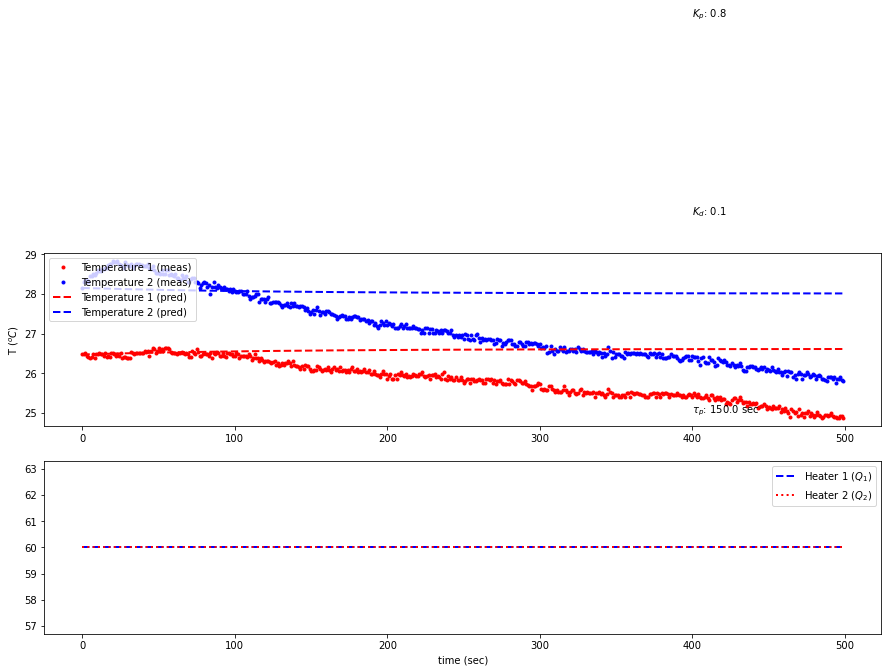

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# initial guesses
x0 = np.zeros(4)
x0[0] = 0.8 # Kp
x0[1] = 0.2 # Kd
x0[2] = 150.0 # taup
x0[3] = 10.0 # thetap

# Import CSV data file
# try to read local data file first
try:
    filename = 'data.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)
Q1_0 = data['Q1'].values[0]
Q2_0 = data['Q2'].values[0]
T1_0 = data['T1'].values[0]
T2_0 = data['T2'].values[0]
t = data['Time'].values - data['Time'].values[0]
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
Qf1 = interp1d(t,Q1)
Qf2 = interp1d(t,Q2)

# define first-order plus dead-time approximation
def fopdt(T,t,Qf1,Qf2,Kp,Kd,taup,thetap):
    #  T      = states
    #  t      = time
    #  Qf1    = input linear function (for time shift)
    #  Qf2    = input linear function (for time shift)
    #  Kp     = model gain
    #  Kd     = disturbance gain
    #  taup   = model time constant
    #  thetap = model time constant
    # time-shift Q
    try:
        if (t-thetap) <= 0:
            Qm1 = Qf1(0.0)
            Qm2 = Qf2(0.0)
        else:
            Qm1 = Qf1(t-thetap)
            Qm2 = Qf2(t-thetap)
    except:
        Qm1 = Q1_0
        Qm2 = Q2_0
    # calculate derivative
    dT1dt = (-(T[0]-T1_0) + Kp*(Qm1-Q1_0) + Kd*(T[1]-T[0]))/taup
    dT2dt = (-(T[1]-T2_0) + (Kp/2.0)*(Qm2-Q2_0) + Kd*(T[0]-T[1]))/taup
    return [dT1dt,dT2dt]

# simulate FOPDT model
def sim_model(x):
    # input arguments
    Kp,Kd,taup,thetap = x
    # storage for model values
    T1p = np.ones(ns) * T1_0
    T2p = np.ones(ns) * T2_0
    # loop through time steps
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        T = odeint(fopdt,[T1p[i],T2p[i]],ts,args=(Qf1,Qf2,Kp,Kd,taup,thetap))
        T1p[i+1] = T[-1,0]
        T2p[i+1] = T[-1,1]
    return T1p,T2p

# define objective
def objective(x):
    # simulate model
    T1p,T2p = sim_model(x)
    # return objective
    return sum(np.abs(T1p-T1)+np.abs(T2p-T2))

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))
print('Optimizing Values...')

# optimize without parameter constraints
#solution = minimize(objective,x0)

# optimize with bounds on variables
bnds = ((0.4, 1.5), (0.1, 0.5), (50.0, 200.0), (0.0, 30.0))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')

# show final objective
x = solution.x
iae = objective(x)
Kp,Kd,taup,thetap = x
print('Final SSE Objective: ' + str(objective(x)))
print('Kp: ' + str(Kp))
print('Kd: ' + str(Kd))
print('taup: ' + str(taup))
print('thetap: ' + str(thetap))
# save fopdt.txt file
fid = open('fopdt.txt','w')
fid.write(str(Kp)+'\n')
fid.write(str(Kd)+'\n')
fid.write(str(taup)+'\n')
fid.write(str(thetap)+'\n')
fid.write(str(T1_0)+'\n')
fid.write(str(T2_0)+'\n')
fid.close()

# calculate model with updated parameters
T1p,T2p = sim_model(x)

plt.figure(1,figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
plt.ylabel(r'T $(^oC)$')
plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,1)))
plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,1)))
plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,0)) + ' sec')
plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,0)) + ' sec')
plt.legend(loc=2)
plt.subplot(2,1,2)
plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
plt.legend(loc='best')
plt.xlabel('time (sec)')
plt.savefig('fopdt_opt.png')
plt.show()